# Imports

In [1]:
import os
import base64
import joblib
import pandas as pd
import numpy as np
import category_encoders as ce
import json
import joblib
import pickle
import math
import requests
from copy import deepcopy
import seaborn as sns
from uuid import uuid4

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, power_transform, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score,
                            recall_score,
                            f1_score,
                            accuracy_score,
                            roc_auc_score,
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            make_scorer,
                            RocCurveDisplay,
                            auc,
                            roc_curve,
                            precision_recall_curve)

from sklearn.base import BaseEstimator, TransformerMixin

from pandas_profiling import ProfileReport

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
%matplotlib inline

# Custom transformer imports

In [2]:
# WIP preprocessor which assigns categories and compresses some code
#from custom_transformers.preprocessor import ColumnConverter
from custom_transformers.preprocessor_redeploy import ColumnConverter

# WIP ordinal category preprocessor
#from custom_transformers.custom_ordinal_encoder import custom_oe
from custom_transformers.custom_ordinal_encoder_redeploy import custom_oe

#WIP column selector
from custom_transformers.featureselector import SelectColumns

# WIP onehot category preprocessor
from custom_transformers.custom_onehot_encoder import custom_one_hot

# WIP onehot category preprocessor
from custom_transformers.custom_impute_scale import custom_impute_scale


# Functions

In [3]:
def load_train_data():
    df = pd.read_csv(os.path.join("data", "train_data.csv"))
    return df

data_train = load_train_data()

In [4]:
def assign_index(df, indexcol: str):
    _df = df.copy()
    _df = _df.set_index(indexcol)
    return _df

In [5]:
def build_target(df, target: str):
    _df = df.copy()
    _df[target] = np.where(_df[target]== 'Yes', True, False)
    return _df

In [6]:
def load_moment_1():
    data = pd.read_csv(os.path.join("data", "moment_1_requests.csv")).set_index('admission_id')
    moment_1 = (data.observation.apply(json.loads)
            .apply(pd.Series)
            .drop('index', axis=1)
            .drop('admission_id', axis=1))
    #moment_1['predicted_readmitted'] = data['predicted_readmitted'] we don't want the old predictions here
    moment_1['readmitted'] = data['actual_readmitted']
    moment_1 = moment_1.drop(index=moment_1.index[0], axis=0)
    return moment_1

# Function to test if we satisfied requirements:

The first step will make a copy of the X_test and apply the custom converter for the columns - it will update the categories we are interested in (avoid duplicates etc)

In [7]:
def verify_no_discrimination_2(X_test,
                               y_true,
                               y_pred,
                               sensitive_columns = [],
                               max_diff=0.1,
                               average='weighted',
                               min_samples=50):    
    # This time with precision
    
    _df = X_test.copy()
    
    results = {}
    
    cc = ColumnConverter()
    _df = cc.fit_transform(_df)
    
    for column in sensitive_columns:  
        sensitive_classes = _df[column].unique()
        is_satisfied = True
        precision_scores = {}
        
        for sensitive_class in sensitive_classes:
            mask = (_df[column] == sensitive_class)
            if np.sum(mask) > min_samples:
                precision_scores[sensitive_class] = precision_score(y_true[mask],
                                                      y_pred[mask],
                                                      pos_label=1,
                                                      labels=np.unique(y_pred[mask]))
        
        diff = np.max(list(precision_scores.values())) - np.min(list(precision_scores.values()))
        if diff > max_diff:
            is_satisfied = False
        
        results[column] = [precision_scores, diff, is_satisfied]
    
    return results

# Loading data

In [50]:
target = 'readmitted'
index_col = 'admission_id'

In [51]:
data_old = load_train_data()
data_old = assign_index(data_old, index_col)
data_old = build_target(data_old, target)

In [52]:
moment_1 = load_moment_1()
moment_1 = build_target(moment_1, target)

In [53]:
data_train = pd.concat([data_old, moment_1], axis=0)

In [12]:
#List of all features (n=numerical, uc=unordered actegory, oc=ordered category, b=boolean)

all_features = ['patient_id', #identifier
                'race', #uc
                'gender', #uc
                'age', #oc
                'weight', #oc               
                'admission_type_code', #uc
                'discharge_disposition_code', #uc
                'admission_source_code', #uc
                'time_in_hospital', #n
                'payer_code', #uc
                'medical_specialty', #uc
                'has_prosthesis', #b
                'complete_vaccination_status', #uc
                'num_lab_procedures', #n
                'num_procedures', #n
                'num_medications', #n
                'number_outpatient', #n
                'number_emergency', #n
                'number_inpatient', #n
                'diag_1', #uc
                'diag_2', #uc
                'diag_3', #uc
                'number_diagnoses', #n
                'blood_type', #uc
                'hemoglobin_level', #n
                'blood_transfusion', #b
                'max_glu_serum', #oc
                'A1Cresult', #oc
                'diuretics', #b
                'insulin', #b
                'change', #b
                'diabetesMed'] #b]

num_features = ['time_in_hospital', 
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'number_diagnoses',
                'hemoglobin_level']

bool_features = ['has_prosthesis',
                 'blood_transfusion',
                 'diuretics',
                 'insulin',
                 'change',
                 'diabetesMed']

cat_features = ['race',
                'gender',
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code', 
                'payer_code',
                'medical_specialty',
                'diag_1',
                'diag_2',
                'diag_3',
                'blood_type']

ord_cat_features = ['age',
                    'weight',
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]

# missing features: date of admission and date of release

### Test train split

In [13]:
# with shuffled samples
df_train, df_test = train_test_split(data_train, test_size=0.2, random_state=42, stratify=None, shuffle=True)

### Dealing with unbalanced train data:
1. Going to use random oversampling (see previous deployment)

In [14]:
# get counts and split tables
count_f, count_t = df_train[target].value_counts()
df_f = df_train[df_train[target] == False]
df_t = df_train[df_train[target] == True]

In [15]:
# oversampling (lots of duplication of positive classes)
df_t_oversampled = df_t.sample(count_f, replace=True)
df_train_oversampled = pd.concat([df_t_oversampled, df_f], axis=0)
#sort it to maintain some kind of order
df_train_oversampled = df_train_oversampled.sort_index()

### Test train split and selection

In [16]:
# without random oversampling
#X_train = df_train.drop(target, axis=1)
#y_train = df_train[target]

# with random oversampling
X_train = df_train_oversampled.drop(target, axis=1)
y_train = df_train_oversampled[target]

#test data
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [17]:
selected_features = ['time_in_hospital', 
                     'num_lab_procedures',
                     'num_procedures',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',
                     'number_diagnoses',
                     'hemoglobin_level',
                     
                     #'has_prosthesis',
                     'blood_transfusion',
                     #'diuretics',
                     'insulin',
                     'change',
                     'diabetesMed',
                     
                     'race',
                     'gender',
                     'admission_type_code', 
                     'discharge_disposition_code',
                     'admission_source_code', 
                     'payer_code',
                     'medical_specialty',
                     #'complete_vaccination_status',
                     'blood_type',
                     'diag_1',
                     'diag_2',
                     'diag_3',
                     
                     'max_glu_serum',
                     'A1Cresult',
                     'age',
                     #'weight'
                     'diag_1_risk',
                     'diag_2_risk', 
                     'diag_3_risk'
                    ]

In [18]:
num_feats = [feat for feat in selected_features if feat in num_features]
cat_feats = [feat for feat in selected_features if feat in cat_features+bool_features+ord_cat_features]
bool_feats = [feat for feat in selected_features if feat in bool_features]
ord_cat_feats = [feat for feat in selected_features if feat in ord_cat_features]

In [19]:
ord_cat_features = ['age',
                    'weight', #lots of missing or unknown values
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]

In [20]:
cat_features = ['race', #done
                'gender', #done
                'admission_type_code', #done 
                'discharge_disposition_code', #done
                'admission_source_code', # done 
                'payer_code', #done (now the insurance column)
                'medical_specialty', #done (any specialty over 100 - lets see how bad it gets)
                'diag_1',
                'diag_2',
                'diag_3',
                'blood_type'
               ] 

1. Not using weight

In [21]:
# This needs to become a custom pipeline - and we need different scalers here

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())]) #StandardScaler or MinMaxScaler
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', ce.OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feats),
        ('cat', categorical_transformer, cat_features)],
remainder="passthrough",sparse_threshold=0)

# Random Forest

Grid search

In [39]:
parameters = {
    'max_depth': [2, 5, 10],
    'max_features': ['auto', 'log2'],
    'class_weight': ["balanced"],
    'n_estimators': [10, 100],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10]
             }
grid_search_pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                           parameters,
                           cv=5,
                           scoring="f1",
                           return_train_score=True))

In [40]:
%%timeit -n 1 -r 1
grid_search_pipeline.fit(X_train, y_train)
grid_search_pipeline.named_steps.gridsearchcv
grid_search_pipeline.named_steps.gridsearchcv.best_params_

1h 9min 34s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [41]:
grid_search_pipeline.named_steps.gridsearchcv.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 10}

best params from grid search

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 10}

model

In [49]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    RandomForestClassifier(max_depth=10,
                           class_weight="balanced",
                           random_state=42, n_jobs=-1,
                           n_estimators = 1000,
                           criterion = 'gini',
                           max_features = 'auto',
                           bootstrap = False,
                           min_samples_split = 2),
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columnconverter',
                 <custom_transformers.preprocessor_redeploy.ColumnConverter object at 0x7f67053fe8d0>),
                ('custom_oe',
                 <custom_transformers.custom_ordinal_encoder_redeploy.custom_oe object at 0x7f67053fe150>),
                ('selectcolumns',
                 <custom_transformers.featureselector.SelectColumns object at 0x7f67053fe250>),
                ('columntransformer',
                 ColumnTransformer(r...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['race', 'gender',
                                                   'admission_type_code',
                                                   'discharge_disposition_code',
                                                   'admission_source_code',
                                                   'payer_code',
                                       

In [48]:
y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.26656239526309905
recall score: 0.5865290068829891
precision score: 0.17247361572936243
discrimination results:


In [24]:
verify_no_discrimination_2(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

{'medical_specialty': [{'unknown': 0.17158725518854137,
   'internalmedicine': 0.18969072164948453,
   'emergency/trauma': 0.19343696027633853,
   'family/generalpractice': 0.18350515463917524,
   'obstetricsandgynecology': 0.5,
   'radiologist': 0.17857142857142858,
   'nephrology': 0.17777777777777778,
   'surgery-general': 0.16759776536312848,
   'orthopedics': 0.13186813186813187,
   'other': 0.125,
   'cardiology': 0.19310344827586207,
   'pulmonology': 0.23728813559322035,
   'psychiatry': 0.2033898305084746,
   'orthopedics-reconstructive': 0.14285714285714285,
   'surgery-cardiovascular/thoracic': 0.12,
   'oncology': 0.15151515151515152,
   'gastroenterology': 0.17857142857142858,
   'urology': 0.1,
   'physicalmedicineandrehabilitation': 0.3,
   'surgery-neuro': 0.0,
   'surgery-vascular': 0.2916666666666667},
  0.5,
  False],
 'payer_code': [{'unknown': 0.19546621043627033,
   'insured': 0.16539634146341464,
   'SP': 0.21923076923076923},
  0.05383442776735459,
  True],
 'ge

In [25]:
plt.rcParams["figure.figsize"] = [3, 3]

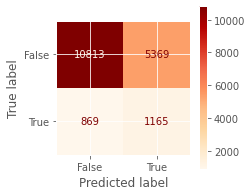

In [26]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

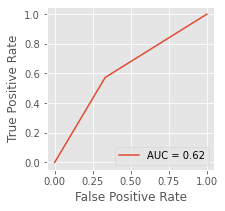

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

### Evaluation and setting threshold:
1. The client wants at least 50% to be correct

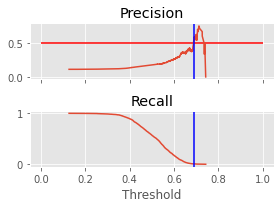

In [28]:
y_pred_probas = pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]
threshold_rq = thresholds[min_index]
y_pred = (y_pred_probas >= threshold_rq)
plt.rcParams["figure.figsize"] = [4, 3]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
precision = precision[:-1]
recall = recall[:-1]
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax1.axvline(x=threshold_rq, color='blue')
ax2.set_title('Recall')
ax2.axvline(x=threshold_rq, color='blue')
fig.tight_layout()
plt.show()

In [29]:
print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.01644100580270793
recall score: 0.008357915437561455
precision score: 0.5
discrimination results:


In [30]:
threshold_rq

0.6886123599913498

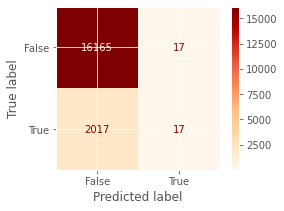

In [31]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

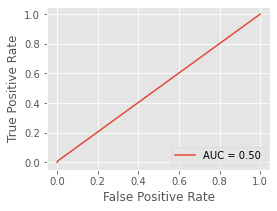

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# Trying to optimize

Best Threshold=0.481328, G-Mean=0.624


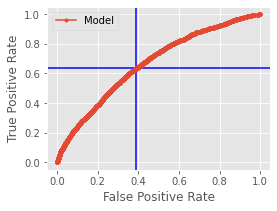

In [33]:
y_pred_probas
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.axvline(x=fpr[ix], color='blue')
plt.axhline(y=tpr[ix], color='blue')
plt.plot(fpr, tpr, marker='.', label='Model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

In [34]:
thresholds[ix]

0.4813282691155798

In [35]:
y_pred = (y_pred_probas >= thresholds[ix])
print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.2689755288262132
recall score: 0.6376597836774828
precision score: 0.17043363994743757
discrimination results:


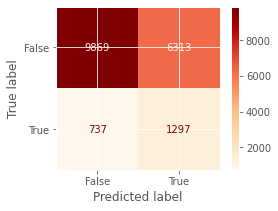

In [36]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

Best Threshold=1.000000, F-Score=0.272


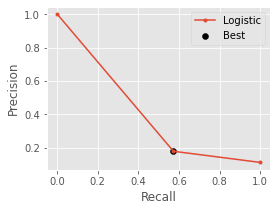

In [37]:
y_pred = (y_pred_probas >= 0.5)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

# Output files (pickling)

In [38]:
TMP_DIR = '/tmp'
with open(os.path.join(TMP_DIR, "columns.json"), 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)

with open(os.path.join(TMP_DIR, "dtypes.pickle"), 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
    
joblib.dump(pipeline, os.path.join(TMP_DIR, 'pipeline.pickle')) 

['/tmp/pipeline.pickle']